## Projeto 2: Classificando tipos acidentes

Para esse projeto, com o intuito de ter mais dados para o treinamento dos modelos, foi necessário adicionar bases dos anos de 2017 à 2019 ao conjunto do ano de 2020 que foi utilizado no projeto 1. Dessa forma, o notebook inicia carregando a base com os dados dos 4 anos agrupados e, em seguida, alguns ajustes são feitos para enfim se iniciar a implementação dos modelos

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import optuna

In [2]:
main_df = pd.read_csv('acidentes_group.csv', index_col=0)

In [3]:
# número de ocorrência das classes
main_df['tipo'].value_counts()

COLISÃO              27473
ABALROAMENTO          8224
CHOQUE                1485
ATROPELAMENTO          918
ENGAVETAMENTO          397
ACID. DE PERCURSO      149
TOMBAMENTO              98
CAPOTAMENTO             82
Name: tipo, dtype: int64

### Ajustes na discrepancia de ocorrência das classes

In [4]:
df_colisao = main_df[main_df['tipo'] == 'COLISÃO']
df_colisao = df_colisao.reset_index(drop=True)
df_colisao.drop(df_colisao.loc[:7000].index, inplace=True)
df_colisao.shape

(20472, 15)

In [5]:
main_df = main_df[main_df['tipo'] != 'COLISÃO']
main_df.reset_index(drop=True)
main_df.head(2)

,data,natureza_acidente,bairro,tipo,auto,moto,ciclom,ciclista,pedestre,onibus,caminhao,viatura,outros,vitimas,vitimasfatais
1,2020-01-01,SEM VÍTIMA,CORDEIRO,ABALROAMENTO,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,2020-01-01,SEM VÍTIMA,AREIAS,CHOQUE,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [6]:
main_df = pd.concat([main_df, df_colisao], ignore_index=True)
main_df.shape

(31825, 15)

In [7]:
main_df['tipo'].value_counts()

COLISÃO              20472
ABALROAMENTO          8224
CHOQUE                1485
ATROPELAMENTO          918
ENGAVETAMENTO          397
ACID. DE PERCURSO      149
TOMBAMENTO              98
CAPOTAMENTO             82
Name: tipo, dtype: int64

In [8]:
def renameTypes(x):
    if x in ['ENGAVETAMENTO', 'ACID. DE PERCURSO', 'TOMBAMENTO', 'CAPOTAMENTO', 'ATROPELAMENTO']:
        return 'OUTROS'
    else:
        return x

In [9]:
main_df['tipo'] = main_df['tipo'].apply(renameTypes)
main_df['tipo'].value_counts()

COLISÃO         20472
ABALROAMENTO     8224
OUTROS           1644
CHOQUE           1485
Name: tipo, dtype: int64

In [10]:
main_df['bairro'] = main_df['bairro'].astype('category')
main_df['bairro'] = main_df['bairro'].cat.codes
main_df['natureza_acidente'] = main_df['natureza_acidente'].astype('category')
main_df['natureza_acidente'] = main_df['natureza_acidente'].cat.codes
main_df['tipo'] = main_df['tipo'].astype('category')
# main_df['data'] = pd.to_numeric((pd.to_datetime(main_df['data'], format='%Y-%m-%d')))
main_df.head()

,data,natureza_acidente,bairro,tipo,auto,moto,ciclom,ciclista,pedestre,onibus,caminhao,viatura,outros,vitimas,vitimasfatais
0,2020-01-01,1,32,ABALROAMENTO,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,2020-01-01,1,7,CHOQUE,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,2020-01-01,1,69,ABALROAMENTO,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,2020-01-01,1,72,CHOQUE,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,2020-01-01,0,72,CHOQUE,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0


In [11]:
dfDummies = pd.get_dummies(main_df['bairro'], prefix = 'bairro')
main_df = pd.concat([main_df, dfDummies], axis=1)
dfDummies2 = pd.get_dummies(main_df['natureza_acidente'], prefix = 'natureza')
main_df = pd.concat([main_df, dfDummies], axis=1)

In [12]:
main_df = main_df.drop('data', axis=1)

In [13]:
main_df.isna().sum()

natureza_acidente    0
bairro               0
tipo                 0
auto                 0
moto                 0
                    ..
bairro_91            0
bairro_92            0
bairro_93            0
bairro_94            0
bairro_95            0
Length: 206, dtype: int64

In [14]:
main_df = main_df.sample(frac=1)

In [15]:
X_acidentes = main_df.drop('tipo', axis=1)
y_acidentes = main_df['tipo']

Xtrain, Xtest, ytrain, ytest = train_test_split(X_acidentes, y_acidentes, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(Xtrain, ytrain, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

## Predições

#### KNN

In [337]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=22)

In [338]:
#desempenho no treinamento e teste
y1_model = model.fit(Xtrain, ytrain).predict(Xtrain)
y2_model = model.fit(Xtrain, ytrain).predict(Xtest)
accuracy_score(ytrain, y1_model), accuracy_score(ytest, y2_model)

(0.6522388059701493, 0.6460329929300864)

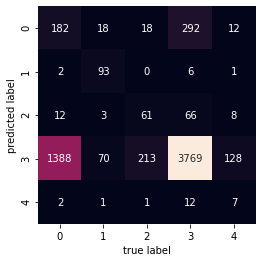

In [339]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, y2_model)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

## Random Forest

In [388]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

### Selecionando hyperparâmetros sobre o conjunto de validação

In [390]:
random_search_cv = RandomizedSearchCV(estimator = RandomForestClassifier(),
                              param_distributions = {'n_estimators':range(10,2000,200)},cv = 3,n_iter = 10)

random_search_cv.fit(X_val,y_val)

#Vamos ver informações relevantes:
print('Melhor número de estimadores: {}'.format(random_search_cv.best_params_['n_estimators']))
print('Desempenho do melhor modelo: {}'.format(round(random_search_cv.best_score_,3)))

Melhor número de estimadores: 1810
Desempenho do melhor modelo: 0.651


In [ ]:
random_search_cv = RandomizedSearchCV(estimator = GradientBoostingClassifier(n_estimators = 1810),
                              param_distributions = {'max_depth': [5, 8, 15, 25, 30]},cv = 3)

random_search_cv.fit(X_val,y_val)

#Vamos ver informações relevantes:
print('Melhor max_depth: {}'.format(random_search_cv.best_params_['max_depth']))
print('Desempenho do melhor modelo: {}'.format(round(random_search_cv.best_score_,3)))

In [341]:
model = RandomForestClassifier(n_estimators=1810)
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)
ypred_train = model.predict(Xtrain)

In [342]:
print("ACC TRAINING:" + str(accuracy_score(ytrain, ypred_train)))
print("ACC TEST:" + str(accuracy_score(ytest, ypred)))

ACC TRAINING:0.7226630007855459
ACC TEST:0.6860958366064415


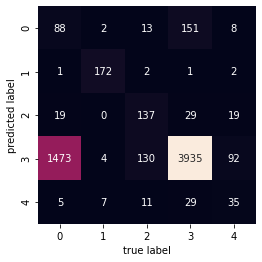

In [343]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, ypred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

## Gradient Boosting

In [17]:
from sklearn.ensemble import GradientBoostingClassifier

### Selecionando hyperparâmetros sobre o conjunto de validação

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

random_search_cv = RandomizedSearchCV(estimator = GradientBoostingClassifier(random_state = 10),
                              param_distributions = {'n_estimators':range(10,100,5)},cv = 3,n_iter = 10)

random_search_cv.fit(X_val,y_val)

#Vamos ver informações relevantes:
print('Melhor número de estimadores: {}'.format(random_search_cv.best_params_['n_estimators']))
print('Desempenho do melhor modelo: {}'.format(round(random_search_cv.best_score_,3)))

In [384]:
random_search_cv = RandomizedSearchCV(estimator = GradientBoostingClassifier(random_state = 0, n_estimators=15),
                            param_distributions = {'max_depth':range(5,16,2), 'min_samples_split':range(200,1001,200)},
                            cv = 3,n_iter = 10)

random_search_cv.fit(X_val,y_val)

#Vamos ver informações relevantes:
print('Max depth: {}'.format(random_search_cv.best_params_['max_depth']))
print('min_samples_split: {}'.format(random_search_cv.best_params_['min_samples_split']))
print('Desempenho do melhor modelo: {}'.format(round(random_search_cv.best_score_,3)))

Max depth: 11
min_samples_split: 200
Desempenho do melhor modelo: 0.668


In [19]:
modelGB = GradientBoostingClassifier(n_estimators=15, max_depth=11, random_state=0,min_samples_split=200 )
modelGB.fit(Xtrain, ytrain)

GradientBoostingClassifier(max_depth=11, min_samples_split=200, n_estimators=15,
                           random_state=0)

In [20]:
ypred = modelGB.predict(Xtest)
ypred_train = modelGB.predict(Xtrain)
print("ACC TRAINING:" + str(accuracy_score(ytrain, ypred_train)))
print("ACC TEST:" + str(accuracy_score(ytest, ypred)))

ACC TRAINING:0.7001178318931658
ACC TEST:0.6917517674783975


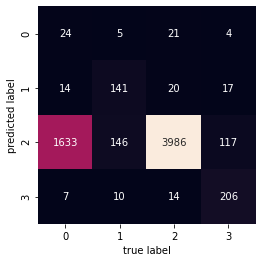

In [387]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, ypred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');